## 모듈 설치

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install konlpy

     |████████████████████████████████| 19.4 MB 483 kB/s 
     |████████████████████████████████| 448 kB 67.6 MB/s 


In [2]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 한글 깨짐 방지

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


## 데이터 확인

In [3]:
#news = pd.read_csv('./drive/MyDrive/crawling_datasets.csv', index_col=0) 
news = pd.read_csv('/content/drive/MyDrive/final_project/crawling_datasets.csv', index_col=0)
news.tail()

,name,headline,date,change
419439,신한지주,신한 디지털 vs 국민 변화… 카드 리딩금융 승부수,2021-12-30,0
419440,신한지주,순혈주의 이어 유리천장도 깨진다…은행권에 부는 '여풍',2021-12-30,0
419441,신한지주,"“리딩금융 승자, 비은행이 가른다” 신한 vs KB, ‘보험 전쟁’",2021-12-30,0
419442,신한지주,은행 개발자 몸값 더 높아진다...부서 넘나들며 플랫폼 특명 완수,2021-12-30,0
419443,신한지주,배당락에 3000선 내줬지만…“코스피 하락폭 예상보다 작았다”,2021-12-30,0


### headline 중복성 검사

In [4]:
news['headline'].nunique(), news['change'].nunique()

(306794, 2)

#### headline 열의 중복 제거 - 중복된 문장 모두 제거
- 여러 종목에 중복된 문장이 있으면 한 종목에 편향적일 수 있어 모두 제거

In [5]:
news.drop_duplicates(subset=['headline'], inplace=True, keep=False)

In [6]:
news.reset_index(drop=True, inplace=True)

In [7]:
news.tail(3)

,name,headline,date,change
244716,신한지주,"“리딩금융 승자, 비은행이 가른다” 신한 vs KB, ‘보험 전쟁’",2021-12-30,0
244717,신한지주,은행 개발자 몸값 더 높아진다...부서 넘나들며 플랫폼 특명 완수,2021-12-30,0
244718,신한지주,배당락에 3000선 내줬지만…“코스피 하락폭 예상보다 작았다”,2021-12-30,0


- 약 데이터가 41만9천개에서 중복된 문장을 모두 빼고 나니 24만4천개 정도 남았다

## 데이터 정제

- 특정 종목의 상승 하락과 무관하다고 판단되는 헤드라인은 데이터에서 제외시킨다.
- 생톡관심종목,사진,포토, 부고,인사,부음 <표>,프로필, 오늘의 메모,집중관찰,<오늘의 화제주>,특징주,게임소개 등 헤드라인 처음에 시작하는 단어 제외시키기

In [13]:
# [인사] 헤드라인 제거 후 비교
news_temp = news[~news.headline.str.startswith("[인사]")]
len(news),len(news_temp)

(244719, 244620)

In [14]:
useless = ["[생톡관심종목]",'[사진]','[포토]','[부고]','[인사]','[부음]','<표>','[프로필]','[오늘의 메모]','[집중관찰]','<오늘의 화제주>','[특징주]','[게임소개]']
print("전체 데이터 개수 : ",len(news))
for eliminate_word in useless:
  news = news[~news['headline'].str.startswith(eliminate_word)]
print("남은 데이터 개수 ",len(news))

전체 데이터 개수 :  244719
남은 데이터 개수  241727


**전체 데이터에서 약 3000개 정도 삭제된 것으로 확인됨**

### 형태소 분석 전 전처리 기준
- 구두점
    - 구두점으로 표기된 형태는 공백으로 replace 처리하면서 1차 전처리 진행
  
- 한자
    - 헤드라인에 표기된 한자 자체만으로도 뜻이 있는 경우가 많았기에 자주 사용되는 한자로 표기되는 경우는 한글로 변경 작업 진행
    - ex) 국가명, 대통령 성씨, 기관(은행, 중소기업, 종목) 등이 포함됨
  
- 영어
    - 영어가 포함된 단어는 종목이름이 과반 이상이나, M&A, R&D, GDP 등 주요 경제 용어가 다수 포함되어 있어 띄어쓰기 기준으로라도 포함 진행
  
- 숫자
    - 숫자는 제외시킴
    - 경제 관련 기사에서 숫자 지표는 헤드라인 논조에서 중요한 역할을 차지할 수 있으나, 단위, 시간 등에 따라 다른 숫자에 대한 명확한 기준이 없기에 제외시킴
  
- 특수문자
    - ↓ , ↑ 와 같은 경우, 특수문자 자체로도 의미가 형성되므로 하락과 상승으로 변경 후 진행

- 기타
    - 헤드라인에 "미리보는"이라는 단어는 종목 상승,하락에 영향을 미치지 않는 것으로 판단되나 많은 양을 포함하므로 공백으로 제거 
  
**1차 전처리가 끝난 후, 한글, 영어, 띄어쓰기를 제외한 모든 표현 삭제(정규표현식 이용)** 

In [15]:
import re

def apply_regular_expression(headline):
  # 한글 추출 규칙 : 띄어쓰기(1 개)를 포함한 한글과 대문자, ... …는 반드시 공백으로 처리해야 띄어쓰기 유지
  headline = headline.replace("…"," ") # 구두점으로 표기하고 띄어쓰기가 반영이 되지 않은 것 처리
  headline = headline.replace(".."," ") # 구두점으로 표기하고 띄어쓰기가 반영이 되지 않은 것 처리
  headline = headline.replace("·"," ") # 구두점으로 표기하고 띄어쓰기가 반영이 되지 않은 것 처리

  # 국가나 기관등을 한자로 표기하는 경우가 많아 전처리 진행
  headline = headline.replace("中企","중소기업") # 중국과 혼동 피하기 위해 먼저 전처리(중국과 구분짓기 위함)
  headline = headline.replace("中","중국")
  headline = headline.replace("日","일본")
  headline = headline.replace("韓","한국")
  headline = headline.replace("美","미국")
  headline = headline.replace("銀","은행")
  headline = headline.replace('株','종목') # 많이 쓰이는 한자
  # 대동령을 한자로 표기하는 경우가 많아 전처리 진행
  headline = headline.replace('文','문재인')
  headline = headline.replace('朴','박근혜')

  headline = headline.replace("↓"," 하락")
  headline = headline.replace("↑", "상승")

  headline = headline.replace("미리보는","") # 미리보는 삭제

  hangeul = re.compile('[^ ㄱ-ㅣ 가-힣a-zA-Z]') # 숫자는 배제!
  result = hangeul.sub('', headline)
  return result

### 상승/하락 별 데이터 분포 확인

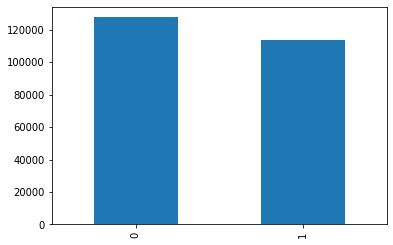

In [16]:
news['change'].value_counts().plot(kind = 'bar');

In [17]:
print(news.groupby('change').size().reset_index(name = 'count'))

   change   count
0       0  127700
1       1  114027


- 주가 변동이 하락인 기사가 조금 더 많다.

### 헤드라인 결측치 확인

In [18]:
print(news.isnull().values.any()) # 널값 없음

False


## 전처리된 텍스트로 데이터 프레임 업데이트
- news['headline']을 전처리한 텍스트로 변경

In [25]:
from tqdm import tqdm

headline_list = []
for idx,row in tqdm(news.iterrows()):
  headline_list.append(apply_regular_expression(row['headline']))
  #per_words = headline_keywords(corpus)
  ## per_words에 넣을 형태소 분석 후 넣을 단어 정리
  #per_words = [x for x in per_nouns if len(x) > 1]  # 한글자 키워드 제거
  #keyword_list.append(per_nouns)

news['headline'] = headline_list
news.tail() 

241727it [00:30, 7980.68it/s]


,name,headline,date,change
244714,신한지주,신한 디지털 vs 국민 변화 카드 리딩금융 승부수,2021-12-30,0
244715,신한지주,순혈주의 이어 유리천장도 깨진다 은행권에 부는 여풍,2021-12-30,0
244716,신한지주,리딩금융 승자 비은행이 가른다 신한 vs KB 보험 전쟁,2021-12-30,0
244717,신한지주,은행 개발자 몸값 더 높아진다 부서 넘나들며 플랫폼 특명 완수,2021-12-30,0
244718,신한지주,배당락에 선 내줬지만 코스피 하락폭 예상보다 작았다,2021-12-30,0


## 데이터 분리 - train (2012 ~ 2019), test (2020 ~ 2021)

In [27]:
news['date'] = pd.to_datetime(news['date'])

split_date = pd.to_datetime('2020-01-01')

train = news[news['date'] < split_date]
test = news[news['date'] >= split_date]

In [28]:
len(train), len(test)

(195601, 46126)

- train과 test를 20년도를 기준으로 나누었고 약 8:2 비율로 나뉘었다.

In [29]:
train.head(3)

,name,headline,date,change
0,삼성전자,TV 재계 총수들 일자리 창출과 투자 확대 강조,2012-01-02,1
1,삼성전자,오너 세들 전진배치 명과 암,2012-01-02,1
2,삼성전자,안철수연구소 개장 첫날 또 상한가,2012-01-02,1


- 기존의 공백은 유지되면서 온점과 같은 구두점 등은 모두 제거되었다.

- train headline에 공백만 있거나 빈 값을 가진 행이 있다면 Null로 변경하고, Null 값이 존재하는지 확인

In [30]:
train['headline'] = train['headline'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train['headline'].replace('', np.nan, inplace=True)
print(train.isnull().sum())

name        0
headline    0
date        0
change      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


- 널 값이 없다

In [31]:
len(train), len(train.dropna(how = 'any'))

(195601, 195601)

### test 셋 확인

In [32]:
test['headline'] = test['headline'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
test['headline'].replace('', np.nan, inplace=True)
print(test.isnull().sum())

name        0
headline    0
date        0
change      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [33]:
len(test), len(test.dropna(how = 'any'))

(46126, 46126)

In [34]:
test.tail(20)

,name,headline,date,change
244697,신한지주,신한금융 그룹 CDO에 김명희 부사장 영입,2021-12-24,0
244698,신한지주,신한금융 최고 디지털 책임자에 DT 전문가 김명희 영입,2021-12-24,0
244699,신한지주,신한금융지주 그룹 CDO 김명희 부사장 신규 영입,2021-12-24,0
244701,신한지주,신한금융 그룹 CDO에 김명희 부사장 신규 영입,2021-12-24,0
244702,신한지주,신한금융 김명희 전 국가정보자원관리원장 CDO로 영입 IBM 출신,2021-12-24,0
244703,신한지주,신한금융 김명희 전 국가정보자원관리원장 DT 책임자로 영입,2021-12-24,0
244704,신한지주,신한은행 안정 방점 임원 인사 디지털 전환 효율화 조직개편도,2021-12-28,1
244705,신한지주,신한금융 지배구조 투명성 강화 준법경영 부패방지경영 동시 인증,2021-12-29,0
244706,신한지주,신한금융 준법 부패방지경영 국제표준인증 동시 획득,2021-12-29,0
244707,신한지주,신한금융 준법경영 부패방지경영 국제표준인증 동시 획득,2021-12-29,0


---

## 토큰화 (Tokenization)
- 토큰화 과정에서 불용어를 제거할 예정.
- 불용어는 정의하기 나름, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용하며,
- 추가적으로 풀고자 하는 문제의 데이터를 지속 검토하면서 계속해서 추가해야함.
- 따라서 headline의 텍스트를 유심히 살펴보면서 추가적인 불용어를 선정해줘야 함.

In [ ]:
# 초기 불용어 선정 -> 한글자로 구성된 토큰 및 조사 제거
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','으로','도','을','를','자','에','와','한','하다','에서','에게'] 